# 1. Исходные данные

Файлы для соревнования
* hotels_train.csv - набор данных для обучения
* hotels_test.csv - набор данных для оценки качества
* submission.csv - файл сабмишна в нужном формате

Признаки
* hotel_address - адрес отеля
* review_date - дата, когда рецензент разместил соответствующий отзыв.
* average_score - средний балл отеля, рассчитанный на основе последнего комментария за последний год
* hotel_name - название отеля
* reviewer_nationality - национальность рецензента
* negative_review - отрицательный отзыв, который рецензент дал отелю.
* review_total_negative_word_counts - общее количество слов в отрицательном отзыв
* positive_review - положительный отзыв, который рецензент дал отелю
* review_total_positive_word_counts - общее количество слов в положительном отзыве
* reviewer_score - оценка, которую рецензент поставил отелю на основе своего опыта
* total_number_of_reviews_reviewer_has_given - количество отзывов, которые рецензенты дали в прошлом
* total_number_of_reviews - общее количество действительных отзывов об отеле
* tags - теги, которые рецензент дал отелю.
* days_since_review - продолжительность между датой проверки и датой очистки
* additional_number_of_scoring - есть также некоторые гости, которые просто поставили оценку сервису, а не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat - широта отеля
* lng - долгота отеля


Загрузим необходимые библиотеки и инструменты

In [1]:
# загрузка необходимых библиотек и инструментов
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# загрузка специального инструмента для разбивки:  
from sklearn.model_selection import train_test_split
# импорт необходимых библиотек:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели 
from category_encoders import  OneHotEncoder, OrdinalEncoder
import category_encoders as ce
import re
# фиксируем RANDOM_SEED для воспроизводимости эксперимента
RANDOM_SEED = 42

In [2]:
# загрузка инструмента для лингвистического анализа
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

from nltk.corpus import stopwords
nltk.download('stopwords')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('omw-1.4')
from nltk import pos_tag

import string

from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
# импорт библиотеки функций для работы с операционной системой
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
# подгрузка данных из соревнования
DATA_DIR = 'D:\IDE\data\EDA\PROJECT-3. EDA + Feature Engineering. Соревнование на Kaggle/'
df_train = pd.read_csv(DATA_DIR+'hotels_train.csv', sep=',') 
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv', sep=',') 
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv', sep=',')

# 2. Исследование данных

In [5]:
display(df_test.head())
display(df_test.info())

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

None

In [6]:
display(df_train.head())
display(df_train.info())

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

None

In [7]:
display(sample_submission.head())
display(sample_submission.info())

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


None

In [8]:
# объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем трейн
df_test['sample'] = 0 # помечаем тест
# в тесте у нас нет значения reviewer_score, заполняем нулями:
df_test['reviewer_score'] = 0 
# объединенный датасет
hotels = df_test.append(df_train, sort=False).reset_index(drop=True)

C:\Users\Home\AppData\Local\Temp\ipykernel_13728\2509483896.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hotels = df_test.append(df_train, sort=False).reset_index(drop=True)


Смотрим структуру полученных данных в объединенном датасете

In [9]:
display(hotels)
display(hotels.info())
print(hotels.nunique(dropna=False))

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298,0,0.0
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,9 Knaresborough Place Kensington and Chelsea L...,107,4/19/2017,9.0,Hotel Moonlight,France,No Negative,0,617,Tr s proche du metro Earl s court,10,10,"[' Leisure trip ', ' Group ', ' Club Double or...",106 day,51.494028,-0.191050,1,8.8
515734,Landstra er Hauptstra e 155 03 Landstra e 1030...,272,2/13/2017,8.4,BEST WESTERN PLUS Amedia Wien,Turkey,No Negative,0,3224,The bed was so comfy I stayed with my boyfrie...,93,1,"[' Leisure trip ', ' Couple ', ' Standard Doub...",171 day,48.192379,16.399451,1,9.2
515735,29 31 Gower Street Camden London WC1E 6HG Unit...,457,2/7/2016,6.8,Bloomsbury Palace Hotel,Netherlands,room is really small but guess is normal in L...,12,2751,great location simple check in out nice shower,9,21,"[' Business trip ', ' Solo traveler ', ' Singl...",543 day,51.520795,-0.131084,1,8.3
515736,31 Great Cumberland Place Westminster Borough ...,365,5/21/2017,8.1,The Marble Arch London,United Arab Emirates,No Negative,0,1567,Location and very comfy bed,6,28,"[' Leisure trip ', ' Solo traveler ', ' Deluxe...",74 days,51.515125,-0.160066,1,9.2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

None

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                             1473
lng                                             1473
sample                                             2
reviewer_score                                    38
dtype: int64


In [10]:
# пропуски данных и их количество
print(hotels.isnull().sum())

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
sample                                           0
reviewer_score                                   0
dtype: int64


Столбцы с пропусками данных:
* lat - 3268 строк
* lng - 3268 строк

# 3. Создание новых признаков на основании обработки данных

In [11]:
# исследование данных признака "национальность рецензента"
print(hotels['reviewer_nationality'].value_counts())

 United Kingdom               245246
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
                               ...  
 Comoros                           1
 Anguilla                          1
 Tuvalu                            1
 Cape Verde                        1
 Palau                             1
Name: reviewer_nationality, Length: 227, dtype: int64


Подавляющая часть рецензентов - из Великобритании. Также можно сказать, что первую четверку (основная часть туристов) составляют выходцы из англоговорящих стран. Возможно, рецензент в "своей" стране будет оставлять больше положительных отзывов, чем при поездке за границу, или наоборот. Для возможной корректировки создадим признак, является ли рецензент резидентом.

In [12]:
# удалим пробелы в начале и конце строки 'reviewer_nationality'
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: x.strip())

In [13]:
# закодируем данные признака национальности рецензента
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(hotels['reviewer_nationality'])
hotels = pd.concat([hotels, type_bin], axis=1)

In [14]:
# создадим признак того, что рецензент является резидентом страны
hotels['country'] = hotels['hotel_address'].apply(lambda x: x.split()[-1])
hotels['country'] = hotels['country'].apply(lambda x: 'United Kingdom' if x == 'Kingdom' else x) # поправка на наименование Великобритании (2 слова в наименовании)

hotels['is_resident'] = hotels.apply(lambda row: 1 if row['reviewer_nationality'] == row['country'] else 0, axis=1)

print(hotels['is_resident'].nunique()) # для проверки, количество полученных уникальных значений признака

2


In [15]:
# признак города из адреса отеля
hotels['city'] = hotels['hotel_address'].apply(lambda x: x.split()[-2])
hotels['city'] = hotels['city'].apply(lambda x: 'London' if x == 'United' else x)

In [16]:
from itertools import groupby
display(hotels.groupby(['city']).nunique())

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7,country,is_resident
city,,,,,,,,,,,,,,,,,,,,,
Amsterdam,105,95,731,25,105,180,38376,331,105,49024,...,2,2,2,2,2,2,2,2,1,2
Barcelona,211,156,731,25,211,180,39039,321,196,51636,...,2,2,2,2,2,2,2,2,1,2
London,399,311,731,31,400,199,174305,397,384,208916,...,2,2,2,2,2,2,2,2,1,2
Milan,162,117,731,26,162,171,24030,297,158,31589,...,2,2,2,2,2,2,2,2,1,2
Paris,458,159,731,29,458,200,37388,321,377,49868,...,2,2,2,2,2,2,2,2,1,2
Vienna,158,126,731,19,158,174,24936,286,154,33443,...,2,2,2,2,2,2,2,2,1,2


Все исследуемые отели расположены в Европе. Всего составляется рейтинг 1492 отелей в шести городах 'Amsterdam', 'Barcelona', 'London', 'Milan', 'Paris', 'Vienna'. Большая часть - Париж (458) и Лондон (399)

In [17]:
display(hotels.groupby(['country']).nunique())

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7,is_resident,city
country,,,,,,,,,,,,,,,,,,,,,
Austria,158,126,731,19,158,174,24936,286,154,33443,...,2,2,2,2,2,2,2,2,2,1
France,458,159,731,29,458,200,37388,321,377,49868,...,2,2,2,2,2,2,2,2,2,1
Italy,162,117,731,26,162,171,24030,297,158,31589,...,2,2,2,2,2,2,2,2,2,1
Netherlands,105,95,731,25,105,180,38376,331,105,49024,...,2,2,2,2,2,2,2,2,2,1
Spain,211,156,731,25,211,180,39039,321,196,51636,...,2,2,2,2,2,2,2,2,2,1
United Kingdom,399,311,731,31,400,199,174305,397,384,208916,...,2,2,2,2,2,2,2,2,2,1


In [18]:
# закодируем признак города
hotels['city'] = hotels['city'].astype('category')
hotels['hotel_city'] = hotels['city'].cat.codes

Для заполнения пропусков данных по географическим координатам введем новый признак 'postcode' и произведем рассчет пропусков 'lat' и 'lng'

In [19]:
# создадим новый признак 'postcode' с учетом особенностей почтового индекса в United Kingdom и Netherlands
hotels['postcode'] = hotels['hotel_address'].apply(lambda x: x.split()[-4] + ' ' + x.split()[-3] if x.endswith('United Kingdom') or x.endswith('Netherlands') else x.split()[-3])
# проверка
print(hotels['postcode'].loc[1],'\n',hotels['hotel_address'].loc[1])

1043 EW 
 Arlandaweg 10 Westpoort 1043 EW Amsterdam Netherlands


In [20]:
# сгруппируем данные с информацией о средней географической координате почтовых индексов в переменную coordinate
coordinate = hotels.groupby(['city', 'postcode']).agg({'lat': 'mean', 'lng': 'mean'})
print(coordinate)

                    lat  lng
city      postcode          
Amsterdam 08001     NaN  NaN
          08002     NaN  NaN
          08003     NaN  NaN
          08004     NaN  NaN
          08005     NaN  NaN
...                 ...  ...
Vienna    WC2N 5BY  NaN  NaN
          WC2N 5HX  NaN  NaN
          WC2R 0EU  NaN  NaN
          WC2R 0JJ  NaN  NaN
          WC2R 1HA  NaN  NaN

[3606 rows x 2 columns]


In [21]:
# полученные данные добавим в датасет с суффиксом _coordinate
hotels = hotels.merge(coordinate, on=['city', 'postcode'], suffixes=('', '_coordinate'))

In [22]:
# Заменяем пропущенные координаты значениями, вычисленными по почтовому индексу
hotels['lat'] = np.where(hotels['lat'].isna(), hotels['lat_coordinate'], hotels['lat'])
hotels['lng'] = np.where(hotels['lng'].isna(), hotels['lng_coordinate'], hotels['lng'])
# удаляем лишние промежуточные признаки
hotels = hotels.drop(['lat_coordinate', 'lng_coordinate'], axis=1)
display(hotels)
print(hotels.isnull().sum()) # проверка на пропуски

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7,country,is_resident,city,hotel_city,postcode
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,0,0,0,0,1,Italy,0,Milan,3,20161
1,Via Senigallia 6 20161 Milan Italy,904,6/4/2017,8.1,Hotel Da Vinci,Bulgaria,Good be in a better maintenance,8,16670,Great breakfast and very kind personnel Spacy...,...,0,1,0,1,0,Italy,0,Milan,3,20161
2,Via Senigallia 6 20161 Milan Italy,904,1/6/2017,8.1,Hotel Da Vinci,Germany,When we were watching tv and communicating wi...,38,16670,No Positive,...,1,0,0,1,0,Italy,0,Milan,3,20161
3,Via Senigallia 6 20161 Milan Italy,904,10/22/2016,8.1,Hotel Da Vinci,Ireland,We had carvery dinner on our first night grea...,18,16670,We needed more pillows they came very quick G...,...,0,0,1,1,1,Italy,0,Milan,3,20161
4,Via Senigallia 6 20161 Milan Italy,904,12/12/2015,8.1,Hotel Da Vinci,Austria,Die Adresse ist wrong very difficult to acces...,11,16670,Room decor Fr hst ck,...,0,1,1,0,0,Italy,0,Milan,3,20161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,45 Park Lane Westminster Borough London W1K 1P...,27,12/6/2015,9.4,45 Park Lane Dorchester Collection,United Kingdom,Nothing,2,68,All,...,0,0,0,0,1,United Kingdom,1,London,2,W1K 1PN
515734,45 Park Lane Westminster Borough London W1K 1P...,27,10/16/2016,9.4,45 Park Lane Dorchester Collection,Canada,One ofour luggage qas destroyedbfor the short...,13,68,Easy to get taxi Porters were wonderful,...,0,1,0,0,0,United Kingdom,0,London,2,W1K 1PN
515735,45 Park Lane Westminster Borough London W1K 1P...,27,12/5/2016,9.4,45 Park Lane Dorchester Collection,United Kingdom,nothing,2,68,Service levels excellent superb location,...,0,0,0,0,1,United Kingdom,1,London,2,W1K 1PN
515736,45 Park Lane Westminster Borough London W1K 1P...,27,6/12/2017,9.4,45 Park Lane Dorchester Collection,United Kingdom,No Negative,0,68,excellent staff restaurant Cut food was excel...,...,0,0,0,0,1,United Kingdom,1,London,2,W1K 1PN


hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
sample                                        0
reviewer_score                                0
reviewer_nationality_0                        0
reviewer_nationality_1                        0
reviewer_nationality_2                  

Исследуем признак 'review_date'. Возможно на положительный или отрицательный отзыв может влиять сезон посещения отеля. Возможно в период весна-лето отзывы будут более положительны, чем в период осень-зима.

In [23]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'], dayfirst=False) # преобразование данных в формат datetime
hotels['review_month'] = hotels['review_date'].dt.month # новый признак - преобразование даты в месяц

In [24]:
# закодируем данные в зависимости от сезона и введем новый признак
def review_season (month):
    if month in [3, 4, 5]:
        return (2) # весна
    elif month in [6, 7, 8]:
        return (3) # лето
    elif month in [9, 10, 11]:
        return (4) # осень
    elif month in [12, 1, 2]:
        return (1) # зима

hotels['review_season'] = hotels['review_month'].apply(review_season)

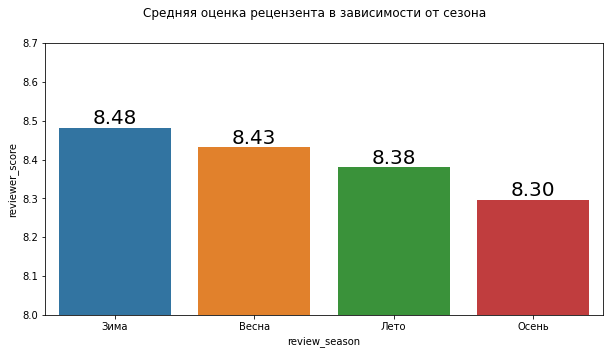

In [25]:
mask = hotels['sample'] == 1
pivot_season = hotels[mask][['review_season', 'reviewer_score']].groupby('review_season').mean()
fig, ax = plt.subplots(figsize=(10, 5))
plt.suptitle('Средняя оценка рецензента в зависимости от сезона')
season = sns.barplot(
    x=pivot_season.index, 
    y=pivot_season['reviewer_score']
)
ax.set_xticklabels(['Зима', 'Весна', 'Лето', 'Осень'])

for p in season.patches:
    season.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()), ha='center', va='bottom', fontsize=20)

plt.ylim(8, 8.7);

По факту получилось, что оценка выше в зимние и весенние месяцы.

In [26]:
# УДАЛЕНИЕ ЛИШНИХ СТОЛБЦОВ
hotels = hotels.drop(['reviewer_nationality', 'review_month', 'country', 'city', 'postcode'], axis=1)

In [27]:
# закодируем признак - наименование отеля
bin_encoder2 = ce.BinaryEncoder(cols=['hotel_name']) # указываем столбец для кодирования
type_bin2 = bin_encoder2.fit_transform(hotels['hotel_name'])
hotels = pd.concat([hotels, type_bin2], axis=1)
display(hotels.head())

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,hotel_name_1,hotel_name_2,hotel_name_3,hotel_name_4,hotel_name_5,hotel_name_6,hotel_name_7,hotel_name_8,hotel_name_9,hotel_name_10
0,Via Senigallia 6 20161 Milan Italy,904,2017-07-21,8.1,Hotel Da Vinci,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,...,0,0,0,0,0,0,0,0,0,1
1,Via Senigallia 6 20161 Milan Italy,904,2017-06-04,8.1,Hotel Da Vinci,Good be in a better maintenance,8,16670,Great breakfast and very kind personnel Spacy...,10,...,0,0,0,0,0,0,0,0,0,1
2,Via Senigallia 6 20161 Milan Italy,904,2017-01-06,8.1,Hotel Da Vinci,When we were watching tv and communicating wi...,38,16670,No Positive,0,...,0,0,0,0,0,0,0,0,0,1
3,Via Senigallia 6 20161 Milan Italy,904,2016-10-22,8.1,Hotel Da Vinci,We had carvery dinner on our first night grea...,18,16670,We needed more pillows they came very quick G...,27,...,0,0,0,0,0,0,0,0,0,1
4,Via Senigallia 6 20161 Milan Italy,904,2015-12-12,8.1,Hotel Da Vinci,Die Adresse ist wrong very difficult to acces...,11,16670,Room decor Fr hst ck,6,...,0,0,0,0,0,0,0,0,0,1


Исследуем признак 'days_since_review'. Удалим лишнюю информацию и приведем к формату 'int'. Хотя, скорее всего, этот признак не оказывает существенного влияния на результат.

In [28]:
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: x.strip('days')) # удаление days
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: x.strip()) # удаление начального и конечного пробела
hotels['days_since_review'] = hotels['days_since_review'].astype('int')

Поскольку и положительный и отрицательный отзывы в записях после посещения отеля оставлены одним и тем же рецензентом, имеет смысл объединить их в один признак и исследовать его.

In [29]:
# приведем к нижнему регистру и уберем пробелы в начале и конце отзыва
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: x.lower()) # .strip()
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.lower()) # .strip()

# удалим 'no negative' или 'no positive' из текста
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: x.replace('no positive', ''))
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.replace('no negative', ''))

In [30]:
# так как по сути негатывный и позитивный отзывы сделаны одним рецензентом, это один отзыв. Объединяем в один признак.
hotels['review'] = hotels['negative_review'] + hotels['positive_review']

In [31]:
# анализируем отзывы
hotels['sent'] = hotels['review'].apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(x))

In [32]:
# проводим векторизацию отзывов
hotels = pd.concat([hotels.drop(['sent'], axis=1), hotels['sent'].apply(pd.Series)], axis=1)

In [33]:
display(hotels.head())

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,hotel_name_6,hotel_name_7,hotel_name_8,hotel_name_9,hotel_name_10,review,neg,neu,pos,compound
0,Via Senigallia 6 20161 Milan Italy,904,2017-07-21,8.1,Hotel Da Vinci,would have appreciated a shop in the hotel th...,52,16670,hotel was great clean friendly staff free bre...,62,...,0,0,0,0,1,would have appreciated a shop in the hotel th...,0.049,0.617,0.334,0.9924
1,Via Senigallia 6 20161 Milan Italy,904,2017-06-04,8.1,Hotel Da Vinci,good be in a better maintenance,8,16670,great breakfast and very kind personnel spacy...,10,...,0,0,0,0,1,good be in a better maintenance great breakf...,0.000,0.398,0.602,0.9273
2,Via Senigallia 6 20161 Milan Italy,904,2017-01-06,8.1,Hotel Da Vinci,when we were watching tv and communicating wi...,38,16670,,0,...,0,0,0,0,1,when we were watching tv and communicating wi...,0.068,0.861,0.071,0.0258
3,Via Senigallia 6 20161 Milan Italy,904,2016-10-22,8.1,Hotel Da Vinci,we had carvery dinner on our first night grea...,18,16670,we needed more pillows they came very quick g...,27,...,0,0,0,0,1,we had carvery dinner on our first night grea...,0.000,0.776,0.224,0.8991
4,Via Senigallia 6 20161 Milan Italy,904,2015-12-12,8.1,Hotel Da Vinci,die adresse ist wrong very difficult to acces...,11,16670,room decor fr hst ck,6,...,0,0,0,0,1,die adresse ist wrong very difficult to acces...,0.449,0.551,0.000,-0.8687


# 4. Отбор признаков

In [34]:
# копируем датасет
hotels_copy = hotels.copy()

In [35]:
# определим признаки с форматом 'object' и удалим их
object_columns = [x for x in hotels_copy.columns if hotels_copy[x].dtypes == 'object']
print(object_columns)
hotels_copy.drop(object_columns, axis = 1, inplace=True)

['hotel_address', 'hotel_name', 'negative_review', 'positive_review', 'tags', 'review']


In [36]:
# также удалим признак 'review_date', т.к. необходимые данные уже получены
hotels_copy = hotels_copy.drop(['review_date'], axis=1)
hotels_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 37 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   days_since_review                           515738 non-null  int32  
 7   lat                                         515738 non-null  float64
 8   lng                                         515738 non-null  float64
 9   sample                                      515738 non-null  int64  
 

Проведем анализ мультиколлинеарности

<AxesSubplot:>

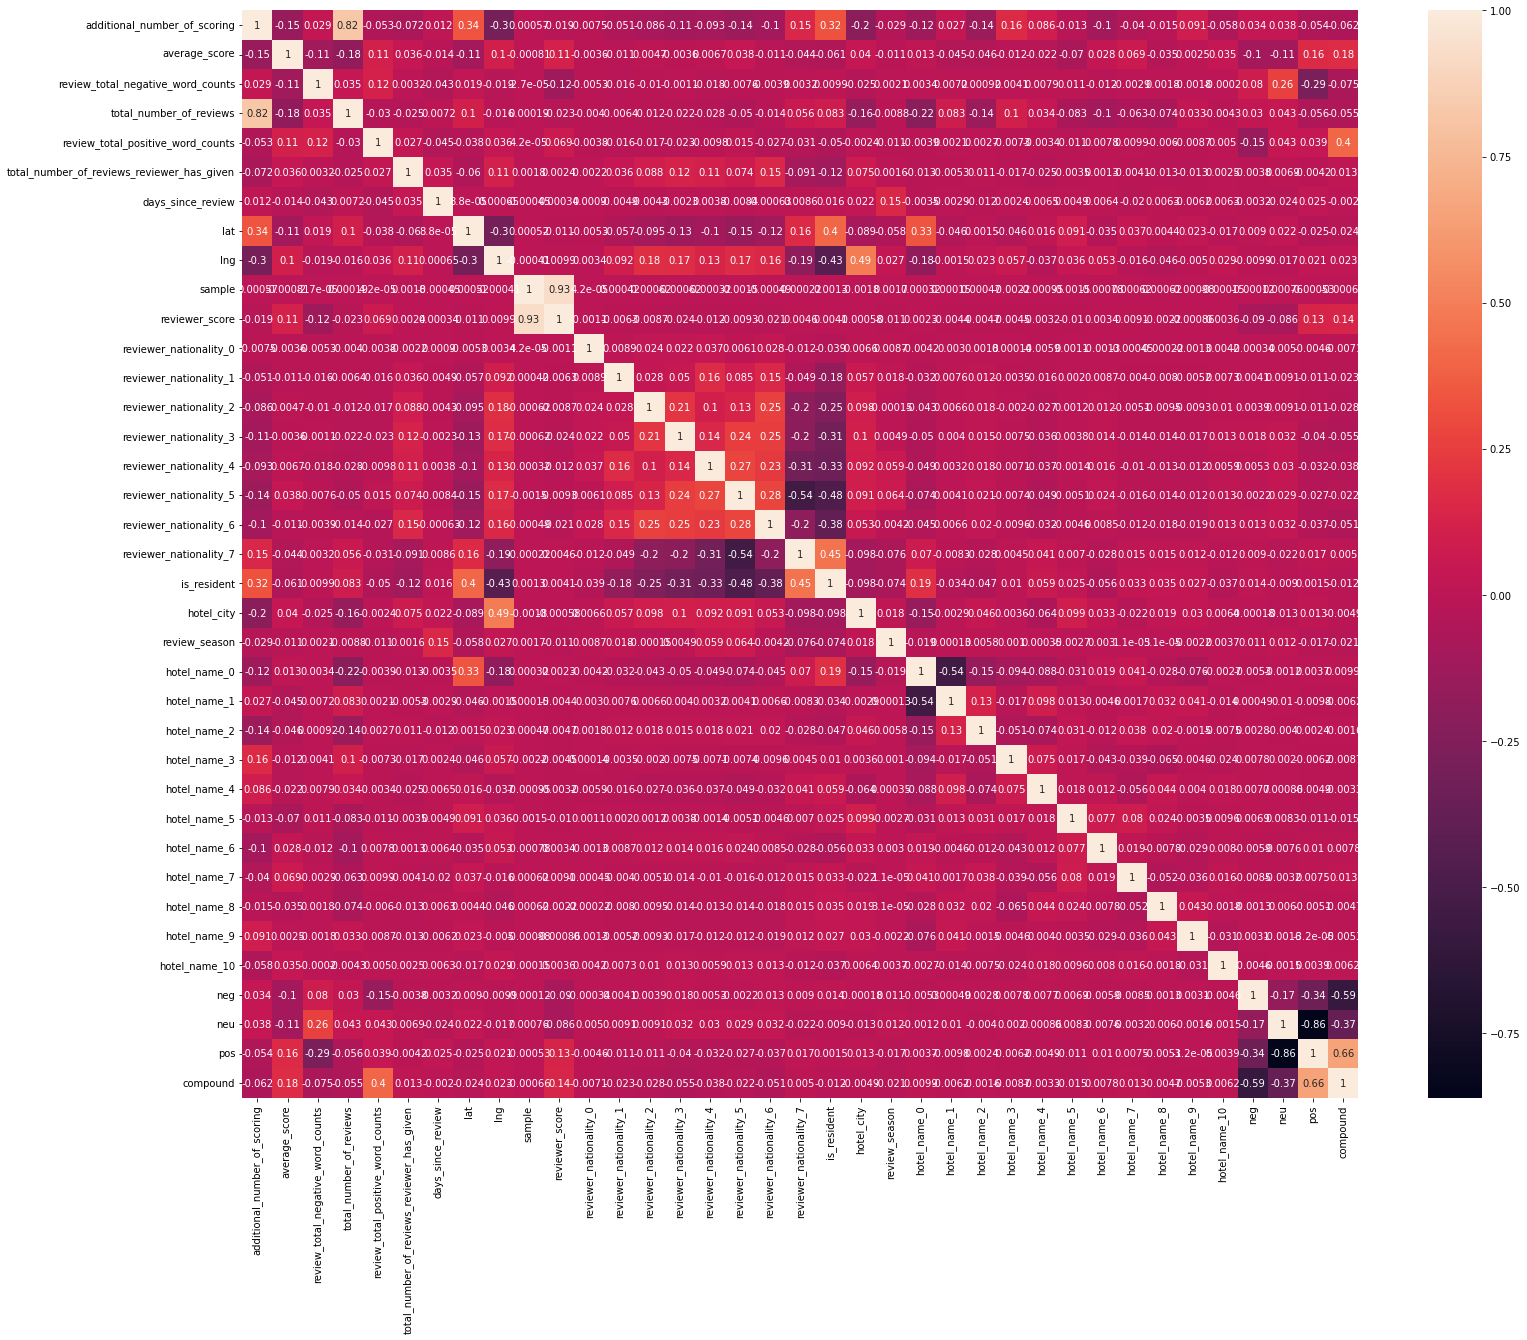

In [37]:
fig = plt.figure(figsize=(25, 20))
sns.heatmap(hotels_copy.corr(), annot=True)

Высокая корреляция признаков 'additional_number_of_scoring'-'total_number_of_reviews'
- 'additional_number_of_scoring' - гости, которые просто поставили оценку сервису, а не оставили отзыв; число указывает, сколько действительных оценок без проверки
- 'total_number_of_reviews' - общее количество действительных отзывов об отеле

Удалим признак 'total_number_of_reviews'

In [38]:
hotels_copy = hotels_copy.drop(['total_number_of_reviews'], axis=1)

# 5. Обучение модели и получение предсказания

In [39]:
# теперь выделим тестовую часть
train_data = hotels_copy.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels_copy.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values
X = train_data.drop(['reviewer_score'], axis=1)

In [40]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
# проверяем размеры:
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 35), (386803, 35), (386803, 34), (309442, 34), (77361, 34))

In [41]:
# Создаём модель
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [42]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.2s finished


In [43]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.1270564585568983
MAE: 0.8878748488379461


MAPE: 0.12705508832068543
MAE: 0.887688957706633

<AxesSubplot:>

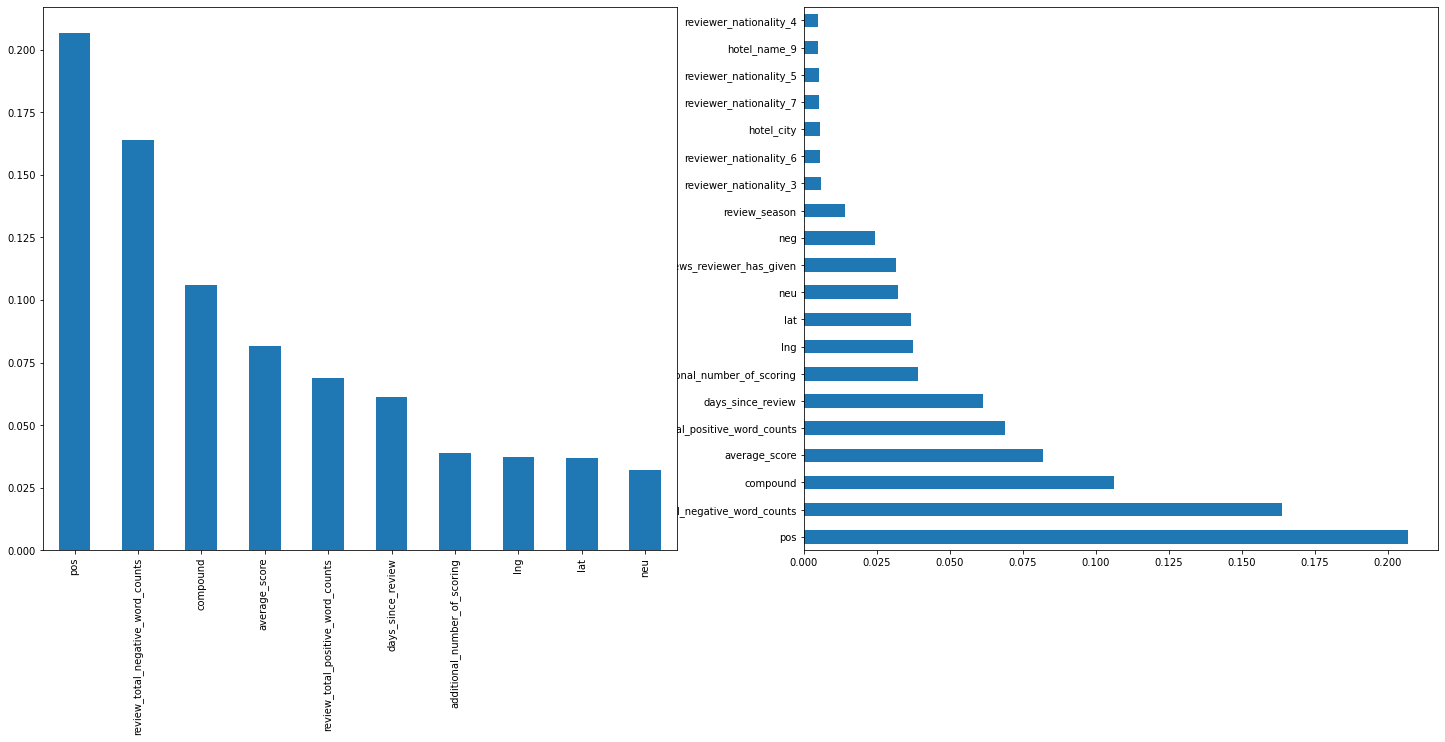

In [44]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (25,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)

plt.subplot(1, 2, 2)
feat_importances.nlargest(20).plot(kind='barh')
plt.subplot(1, 2, 1)
feat_importances.nlargest(10).plot(kind='bar')

In [45]:
test_data = test_data.drop(['reviewer_score'], axis=1)
predict_submission = model.predict(test_data)
sample_submission['reviewer_score'] = predict_submission

#  сохраняем результат:
sample_submission.to_csv('s_submission.csv', index=False)
sample_submission.head(10)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.7s finished


,reviewer_score,id
0,8.969,488440
1,8.970,274649
2,6.209,374688
3,8.244,404352
4,5.373,451596
5,6.612,302161
6,7.864,317079
7,8.771,13963
8,8.160,159785
9,5.860,195089
